In [1]:
## This file contains the basic function of cuffdiff analysis.
## Author: Xiang Li

###Sample
#### Imput Package
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from scipy import stats

In [2]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

In [71]:
PATH_FOLDER='/mnt/d/bioproject/Data/Haihui/Tcf1/Hdac/'
df = pd.read_excel(PATH_FOLDER+'Hdac Treg DEGs.xlsx', sheet_name='all DEGs',\
sep=',', header=1, usecols=['WT2_Treg_D20', 'WT1_Treg_D12', 'WT2_Treg_D12', \
'Hdac12_KO_het1_Treg_D20', 'Hdac12_KO_het1_Treg_D20', 'Hdac12_KO_het2_Treg_D20',\
'Hdac12_KO1_Treg_D20', 'Hdac12_KO2_Treg_D20' ]) #, index_col= )
df=df.dropna(axis=0, how='any')
#df = df[(df >= 0).all(axis=1)]
#df=df.replace(0,0.000001)
df.index.name='gene_id'
df.shape
#df.head


(2041, 7)

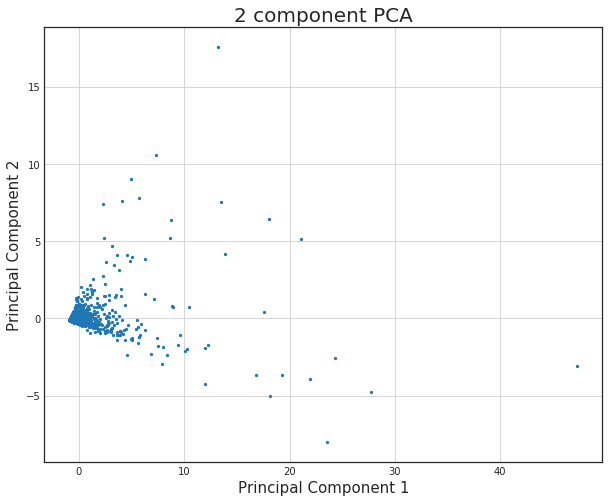

In [99]:
# PCA
df_2 = df.reset_index()
#### Change "gene_id" from index to column
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

features = ['WT2_Treg_D20', 'WT1_Treg_D12', 'WT2_Treg_D12', 'Hdac12_KO_het1_Treg_D20',\
'Hdac12_KO_het2_Treg_D20','Hdac12_KO1_Treg_D20', 'Hdac12_KO2_Treg_D20']

# Separating out the features
x = df_2.loc[:, features].values

# Separating out the target
y = df_2.loc[:,['gene_id']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_2[['gene_id']]], axis = 1)


fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#colors = ['r', 'g', 'b']
#for target, color in zip(targets,colors):
#    indicesToKeep = finalDf['gene_id'] == target
ax.scatter(finalDf.loc[:, 'principal component 1']
               , finalDf.loc[:, 'principal component 2']
               , s = 5)
#ax.legend(targets)
ax.grid()
Parameters_Detail='CD8_HP'
fig.savefig('PCA'+Parameters_Detail+'.png')


In [42]:
# Cluster Map following:
#df_sorted

       WT2_Treg_D20  WT1_Treg_D12  WT2_Treg_D12  Hdac12_KO_het1_Treg_D20  \
count   2041.000000   2041.000000   2041.000000              2041.000000   
mean      21.036831     21.704865     20.876518                22.490538   
std       57.505821     77.951232     69.934524                67.967845   
min        0.026388      0.000000      0.000000                 0.000000   
25%        2.368200      1.693220      1.698230                 1.656400   
50%        6.050010      4.337610      4.217810                 4.557700   
75%       16.659900     13.826500     13.058000                15.356400   
max     1159.360000   1846.270000   1429.650000              1159.760000   

       Hdac12_KO_het2_Treg_D20  Hdac12_KO1_Treg_D20  Hdac12_KO2_Treg_D20  \
count              2041.000000          2041.000000          2041.000000   
mean                 22.189837            21.049460            31.884931   
std                  66.263560            54.184093            97.107594   
min        

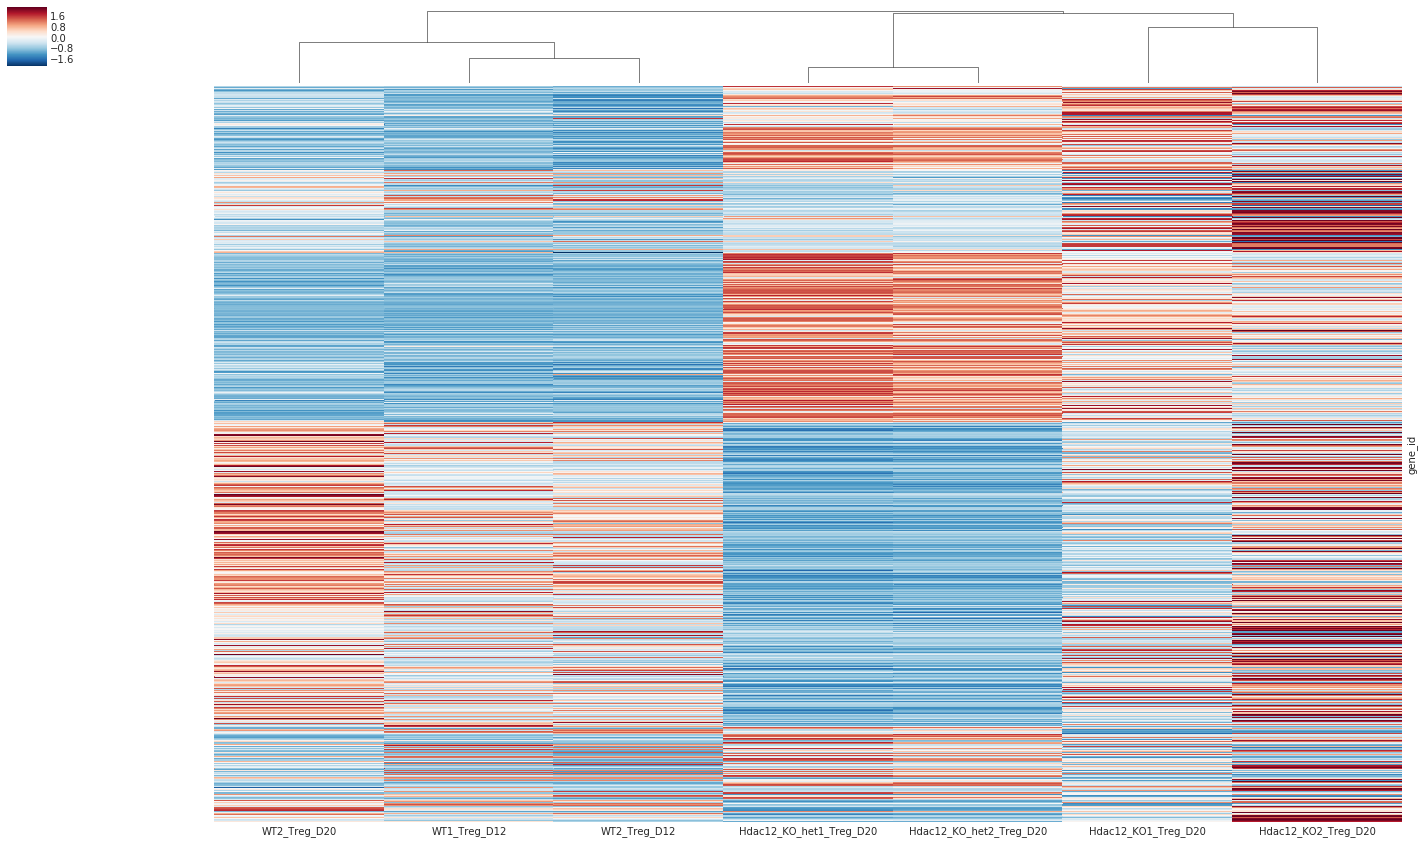

In [100]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=None).fit(df.values)
df['label'] = kmeans.labels_

print(df.describe())

df_sorted = df.sort_values(by=['label'])

df_sorted = df_sorted.drop(['label'], axis=1)

df_sorted.index.name='gene_id'

print(df_sorted.shape)
fig_1 = sns.clustermap( (df_sorted),  yticklabels=False, col_cluster=True,\
z_score=0, cmap="RdBu_r", figsize=(25, 15), row_cluster=False) # 


Parameters_Detail= "z_score=0"

fig_1.savefig('Heatmap1_Hdac_'+Parameters_Detail+'.png')

In [3]:
#Functions to read cuffdiff outputs
def generate_genes_FPKM_df(fname, sample_name_dict):
    df = pd.read_csv(fname, sep='\t', header=0)
    
    FPKM_df = None
    for condition in set(df.condition):
        for replicate in set(df.replicate):
            temp_df = df[(df.condition == condition) & (df.replicate == replicate) & (df.FPKM >=1)].loc[:,['tracking_id', 'FPKM']]
            temp_df.rename(columns={'tracking_id': 'gene_id', 'FPKM': sample_name_dict[(condition, replicate)]}, inplace=True)
            if FPKM_df is None:
                FPKM_df = temp_df
            else:
                #FPKM_df = FPKM_df.merge(temp_df, on='gene_id')
                FPKM_df = FPKM_df.merge(temp_df, how='outer')
    FPKM_df = FPKM_df.dropna(axis=1, how='all')
    FPKM_df = FPKM_df.dropna(axis=0, how='any')
    return FPKM_df

In [4]:
#FPKM
################################################################################
WT_PATH='/home/lxiang/cloud_research/PengGroup/ZZeng/Data/Haihui/Tcf1/HP_RNAseq/cuffdiff/WT/'
WT_sample_name_dict = {('WT_CD8_0h', 0): 'WT1_CD8_0h', ('WT_CD8_0h', 1): 'WT2_CD8_0h', \
                       ('WT_CD8_72h', 0): 'WT1_CD8_72h', ('WT_CD8_72h', 1): 'WT2_CD8_72h' }
WT_FPKM_df = generate_genes_FPKM_df(WT_PATH+'genes.read_group_tracking', WT_sample_name_dict)
################################################################################
################################################################################
DKO_PATH='/home/lxiang/cloud_research/PengGroup/ZZeng/Data/Haihui/Tcf1/HP_RNAseq/cuffdiff/DKO/'
DKO_sample_name_dict = {('DKO_CD8_0h', 0): 'DKO1_CD8_0h', ('DKO_CD8_0h', 1): 'DKO2_CD8_0h', \
                    ('DKO_CD8_72h', 0): 'DKO1_CD8_72h', ('DKO_CD8_72h', 1): 'DKO2_CD8_72h'}
DKO_FPKM_df = generate_genes_FPKM_df( DKO_PATH+'genes.read_group_tracking', DKO_sample_name_dict)
################################################################################
################################################################################
Ctrl_PATH='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/Mar2018/Cuffdiff_Results/Ctrl-n_Ctrl-s/'
Ctrl_sample_name_dict = {('Ctrl-n', 0): 'Ctrl-3n', ('Ctrl-n', 1): 'Ctrl-4n', \
                       ('Ctrl-s', 0): 'Ctrl-3s', ('Ctrl-s', 1): 'Ctrl-3s_fake' }
Ctrl_FPKM_df = generate_genes_FPKM_df(Ctrl_PATH+'genes.read_group_tracking', Ctrl_sample_name_dict)
################################################################################
################################################################################
dKO_PATH='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/Mar2018/Cuffdiff_Results/dKO-n_dKO-s/'
dKO_sample_name_dict = {('dKO-n', 0): 'dKO-3n', ('dKO-n', 1): 'dKO-4n', \
                    ('dKO-s', 0): 'dKO-3s' , ('dKO-s', 1): 'dKO-3s_fake'}
dKO_FPKM_df = generate_genes_FPKM_df(dKO_PATH+'genes.read_group_tracking', dKO_sample_name_dict)
################################################################################
################################################################################

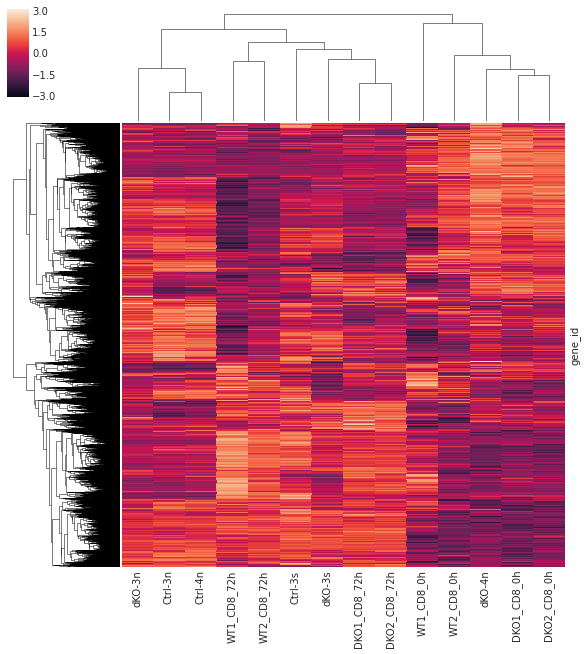

In [16]:
#### FPKM Merge and heatmap
FPKM_df = WT_FPKM_df.merge(DKO_FPKM_df, on='gene_id')
FPKM_df = FPKM_df.merge(Ctrl_FPKM_df, on='gene_id')
FPKM_df = FPKM_df.merge(dKO_FPKM_df, on='gene_id')

FPKM_df = FPKM_df.loc[:,['gene_id','WT1_CD8_0h','WT2_CD8_0h','Ctrl-3n', 'Ctrl-4n', 'DKO1_CD8_0h', 'DKO2_CD8_0h', 'dKO-3n', 'dKO-4n', 'WT1_CD8_72h','WT2_CD8_72h','Ctrl-3s', 'DKO1_CD8_72h', 'DKO2_CD8_72h', 'dKO-3s']]
#FPKM_df.head
FPKM_df=FPKM_df.set_index('gene_id')

#np.log1p(FPKM_df) 
#### This command is only valid for NaN item.
#FPKM_df=FPKM_df.fillna(0)
#FPKM_df
fig_1 = sns.clustermap( np.log1p(FPKM_df),  yticklabels=False, col_cluster=True, z_score=0, cmap="RdBu_r" )
#fig_1 = sns.clustermap( np.log1p(FPKM_df),  yticklabels=False ) #, col_cluster=True,)
#fig_2 = sns.clustermap(FPKM_df, col_cluster=False, yticklabels=False, z_score=0)
#fig_1.savefig('Heatmap1_'+Folder_Name+'.png')
#fig_2.savefig('Heatmap2_'+Folder_Name+'.png')